In [1]:
import json
import numpy as np
import xarray as xr
from dask.distributed import Client
from nmme_download import iri_nmme_models

# directory where new simulation (inputs) and mhw forecast (outputs) is located
BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'

# directory where sst threshold/climatology/trend (inputs) is located
PREDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

# directory where nmme mhw probability is located
OUTDIR = '/Datasets.private/marinehw/nmme_mhw_prob/'

# directory where the marine index mask is located
MASKDIR = '/Datasets.private/marinehw/nmme_marine_index_mask/'

# used model list
with open('model_use_list.json','r',encoding='utf-8') as f:
    json_dict = json.load(f)
model_use_list = json_dict['model_use_list']

dict_model = iri_nmme_models()
avai_model_list = list(dict_model.keys())

 

In [2]:
model_use_list

['CanCM4i-IC3',
 'GEM5-NEMO',
 'GFDL-SPEAR-regridded',
 'NASA-GEOSS2S',
 'COLA-RSMAS-CCSM4',
 'COLA-RSMAS-CESM1',
 'NCEP-CFSv2']

In [3]:
from nmme_hci_climo_threshold import read_marine_index_mask
ds_mask = read_marine_index_mask(MASKDIR)

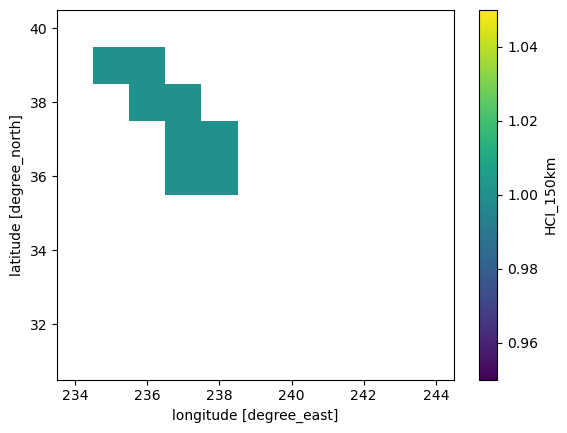

In [5]:
ds_mask['HCI_150km'].plot()

In [6]:
### open local cluster
client = Client(processes=False)
print(client)
print(client.cluster.dashboard_link)

import cftime
ds_list = []
for model in model_use_list:
    ds = xr.open_mfdataset(f'{BASEDIR}{model}*',
        concat_dim='S',
        combine='nested',decode_times=False)
    
    ds['S'] = cftime.num2date(ds['S'],
                                ds.S.units,
                                calendar='360_day')
    
    ds = (ds*ds_mask['HCI_150km'])
    
    ds_list.append(ds)

<Client: 'inproc://10.173.16.4/2314245/1' processes=1 threads=96, memory=0.98 TiB>
http://10.173.16.4:43991/status


In [7]:
ds_merge = xr.concat(ds_list,dim='model').compute()

In [14]:
ds_merge.to_netcdf('/Datasets.private/marinehw/nmme_sst_stat/hci_test_sst_abs.nc')

In [8]:
ds_merge

<xarray.Dataset> Size: 891MB
Dimensions:        (model: 7, M: 30, L: 12, Y: 10, X: 11, S: 402)
Coordinates:
  * L              (L) float32 48B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
  * S              (S) object 3kB 1991-01-01 00:00:00 ... 2024-06-01 00:00:00
  * X              (X) float32 44B 234.0 235.0 236.0 237.0 ... 242.0 243.0 244.0
  * Y              (Y) float32 40B 31.0 32.0 33.0 34.0 ... 37.0 38.0 39.0 40.0
  * M              (M) float32 120B 1.0 2.0 3.0 4.0 5.0 ... 27.0 28.0 29.0 30.0
Dimensions without coordinates: model
Data variables:
    sst            (model, M, L, Y, X, S) float32 446MB nan nan nan ... nan nan
    sst_regridded  (model, L, M, Y, X, S) float32 446MB nan nan nan ... nan nan

In [9]:
da_sst_transpose = ds_merge['sst_regridded'].transpose('model', 'M', 'L', 'Y', 'X', 'S')

In [10]:
ds_merge['sst'][2,:,:,:,:] = da_sst_transpose[2,:,:,:,:]

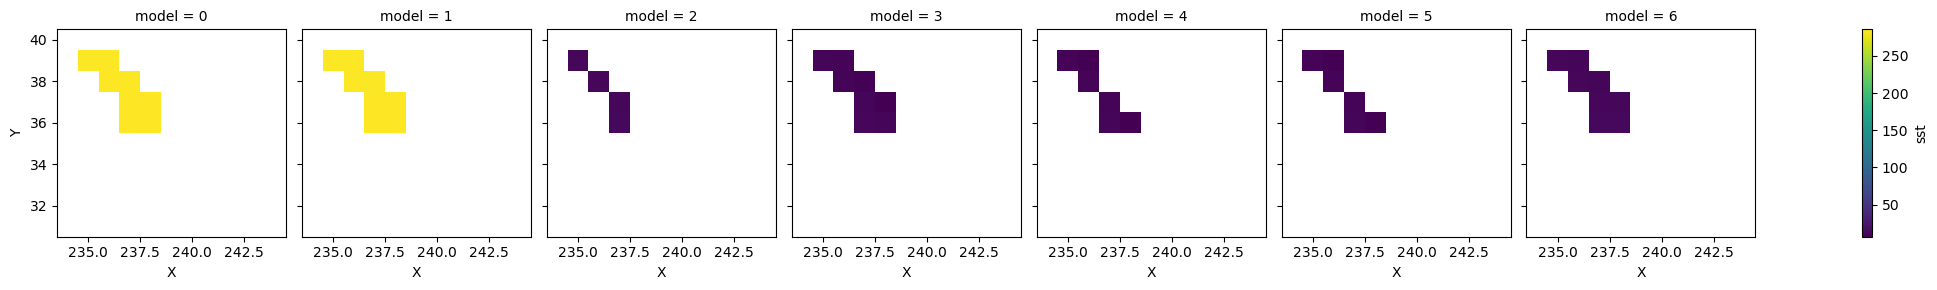

In [11]:
ds_merge.sst.isel(M=0,L=0,S=0).plot(col='model')

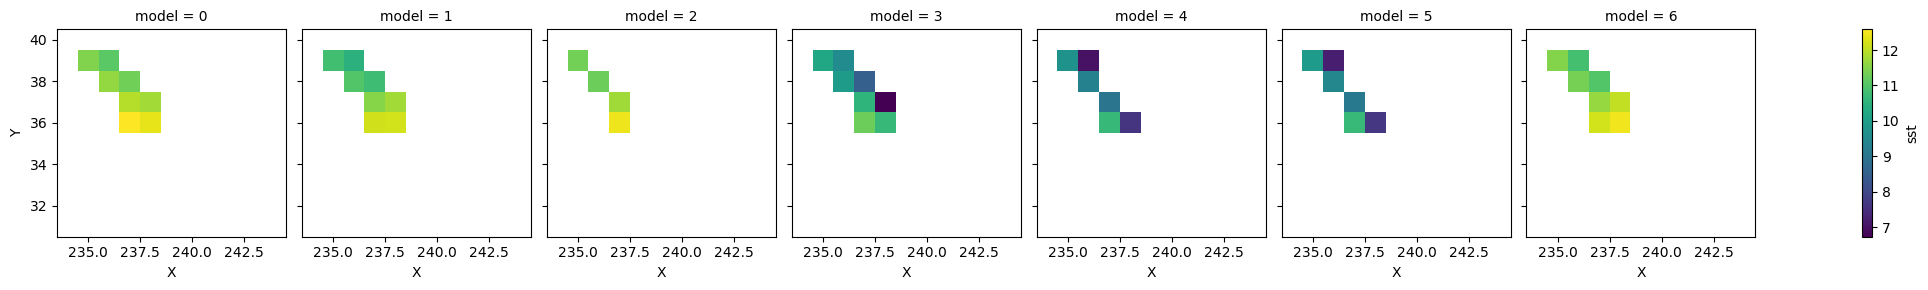

In [12]:
da_sst_abs = ds_merge.sst.copy()
da_sst_abs[0,:,:] -= 273.15
da_sst_abs[1,:,:] -= 273.15 
da_sst_abs.isel(M=0,L=0,S=0).plot(col='model')

In [13]:
da_climo = ds_merge.sst.groupby('S.month').mean()

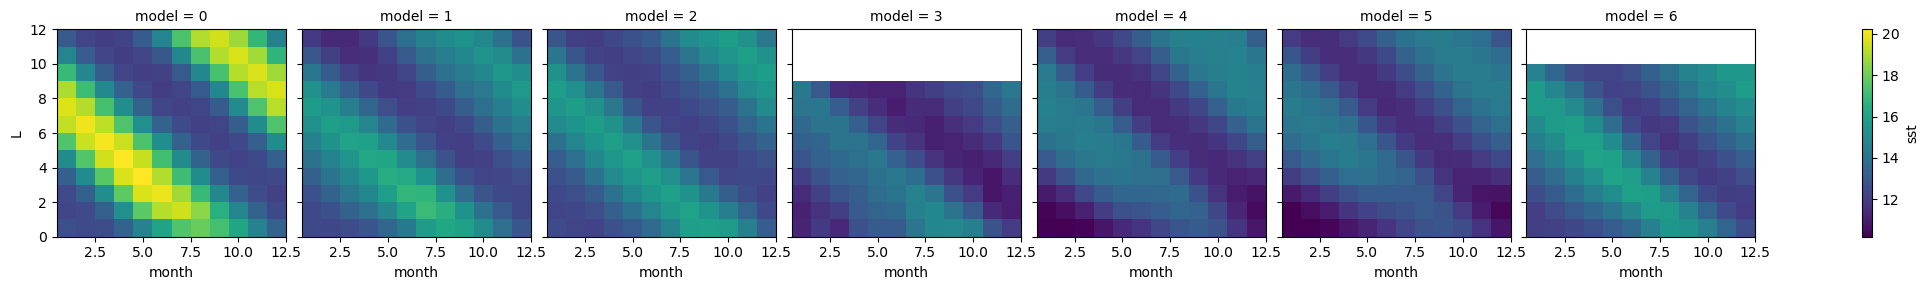

In [15]:
da_sst_climo = da_climo.mean(dim=['X','Y'])
da_sst_climo[0,:,:] -= 273.15
da_sst_climo[1,:,:] -= 273.15 
da_sst_climo.mean(dim='M').plot(col='model')

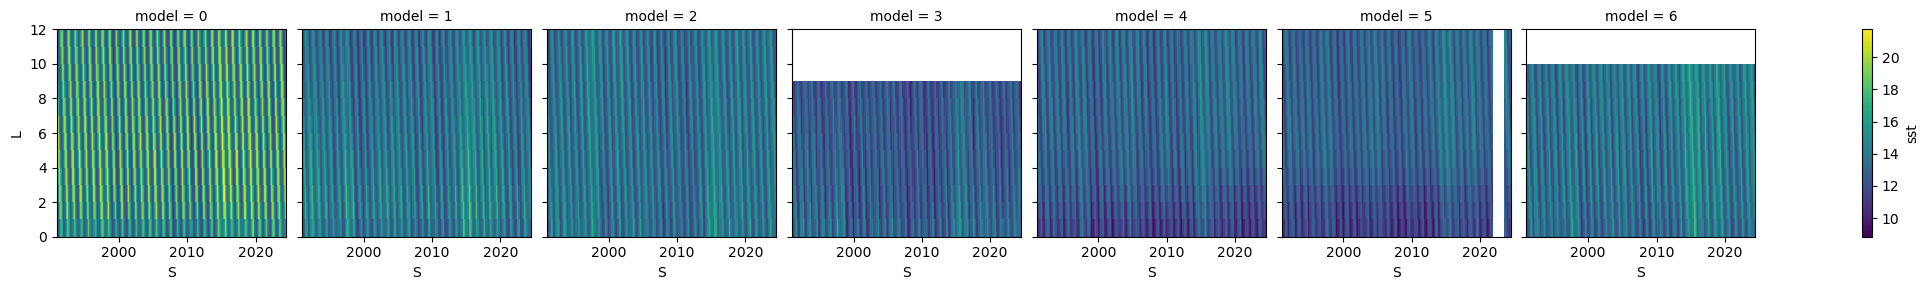

In [16]:
da_sst = ds_merge.sst.mean(dim=['X','Y'])
da_sst[0,:,:] -= 273.15
da_sst[1,:,:] -= 273.15 
da_sst.mean(dim='M').plot(col='model')

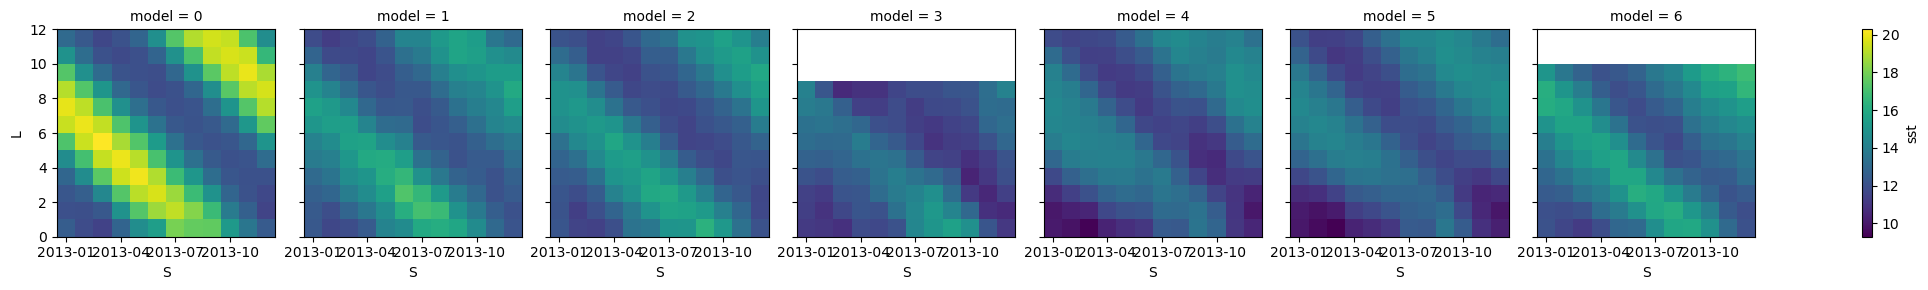

In [17]:
da_sst.mean(dim='M').sel(S=slice('2013-01','2013-12')).plot(col='model')

In [18]:
da_ssta = ds_merge.sst.groupby('S.month')-da_climo

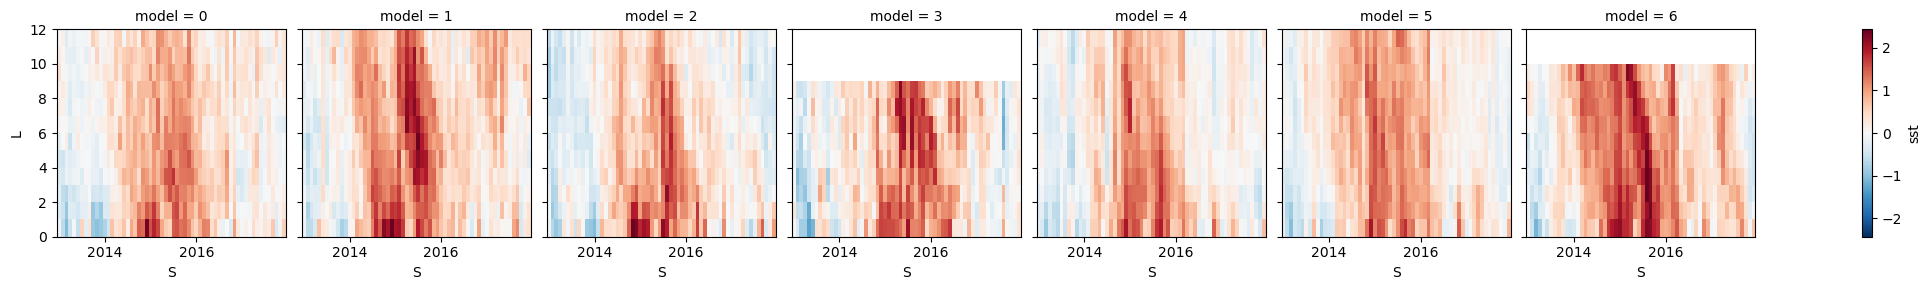

In [19]:
da_ssta.mean(dim=['X','Y']).mean(dim='M').sel(S=slice('2013-01','2017-12')).plot(col='model')

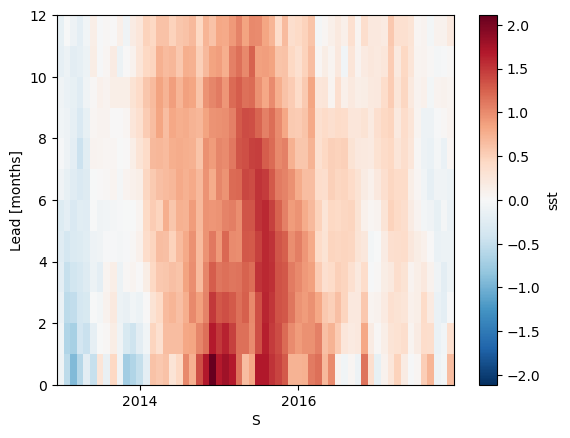

In [20]:
da_ssta.mean(dim=['X','Y']).mean(dim='M').mean(dim='model').sel(S=slice('2013-01','2017-12')).plot()

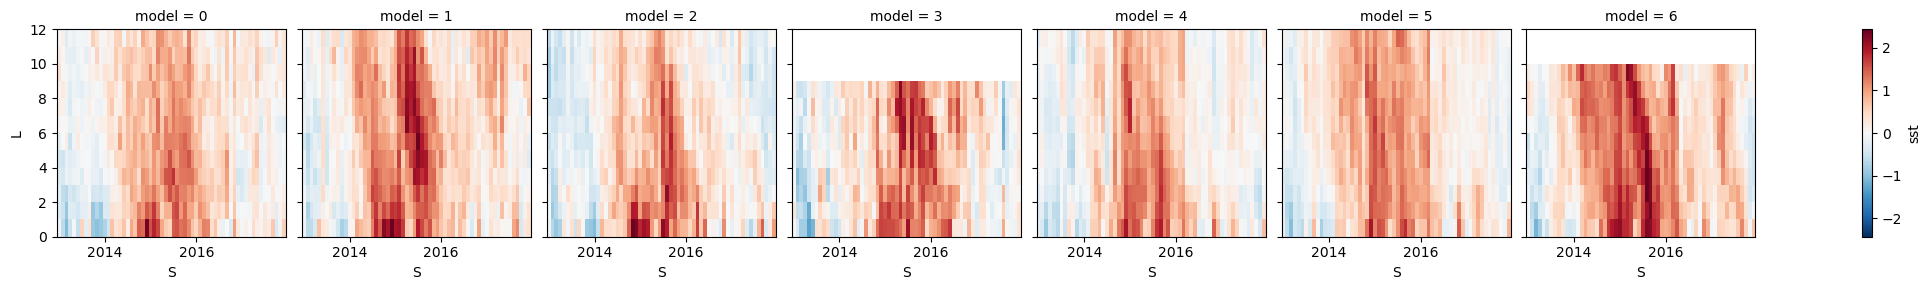

In [21]:
da_ssta.mean(dim=['X','Y']).mean(dim='M').sel(S=slice('2013-01','2017-12')).plot(col='model')

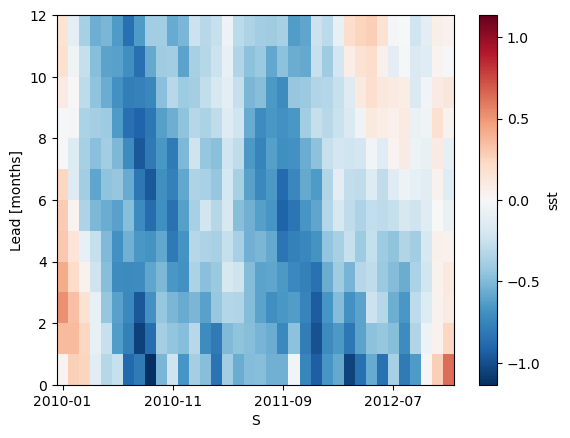

In [22]:
da_ssta.mean(dim=['X','Y']).mean(dim='M').mean(dim='model').sel(S=slice('2010-01','2012-12')).plot()

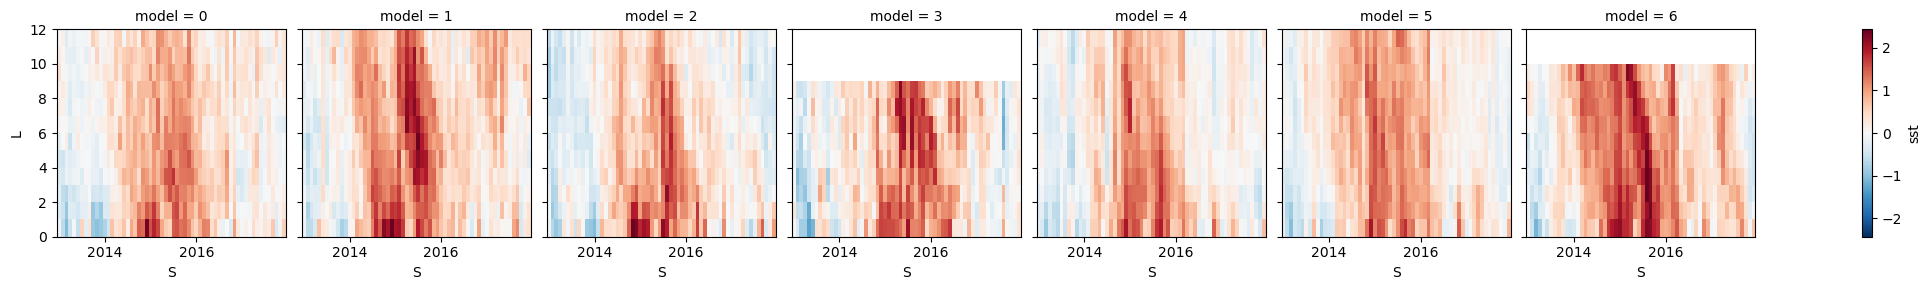

In [23]:
da_ssta.mean(dim=['X','Y']).mean(dim='M').sel(S=slice('2013-01','2017-12')).plot(col='model')

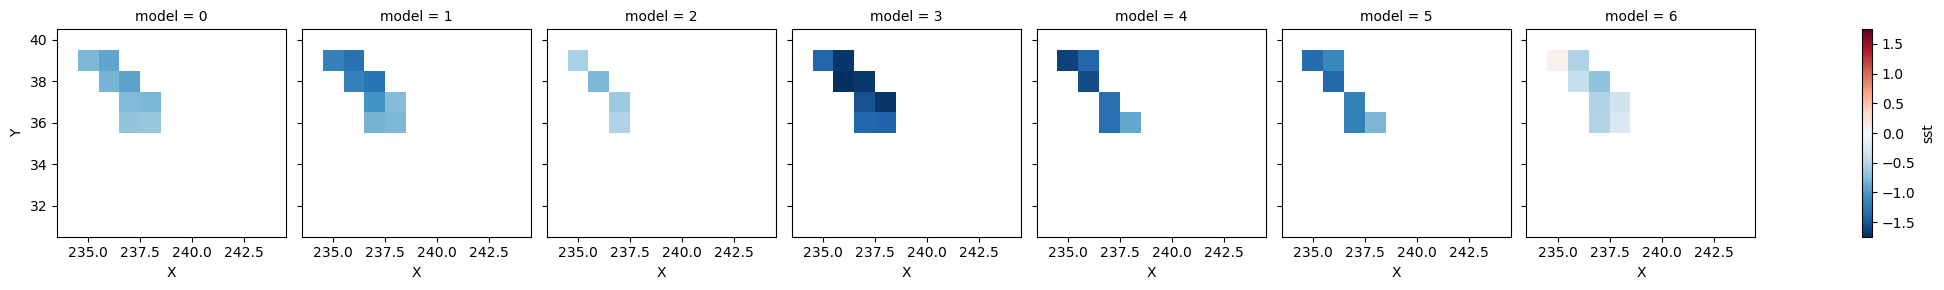

In [24]:
da_ssta.isel(M=0,L=0,S=0).plot(col='model')

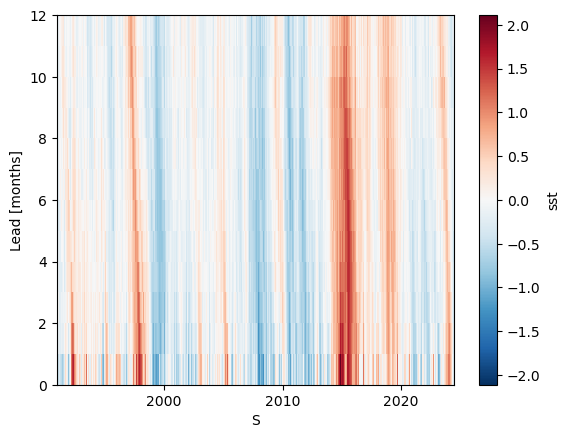

In [25]:
da_total_concat_sub = da_ssta
da_total_concat_mmm = da_total_concat_sub.mean(dim=['X','Y']).mean(dim='M').mean(dim='model')
da_total_concat_mmm.plot()

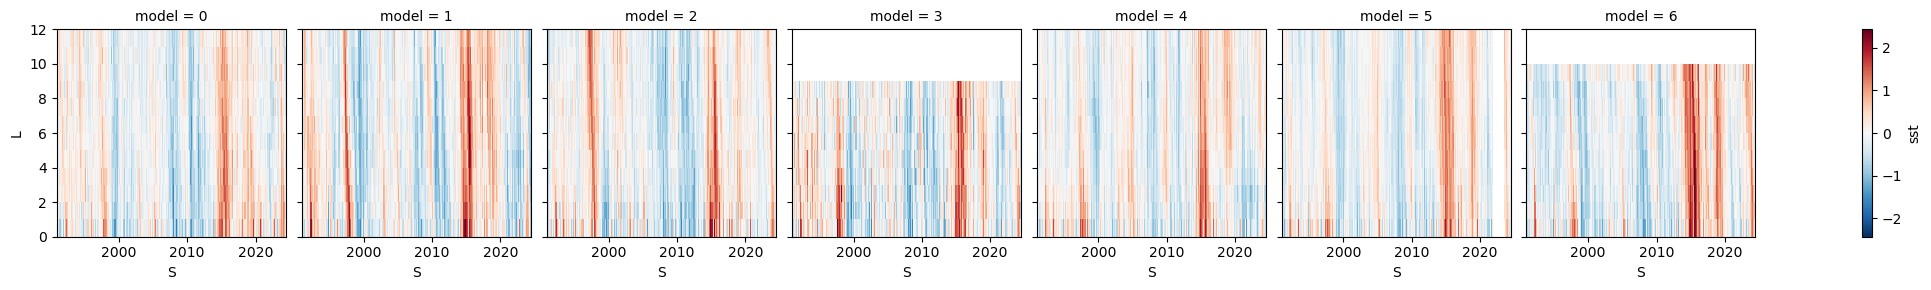

In [26]:
da_total_concat_m = da_total_concat_sub.mean(dim=['X','Y']).mean(dim='M')
da_total_concat_m.plot(col='model')

Text(0.5, 1.0, 'Time axis is the initial time')

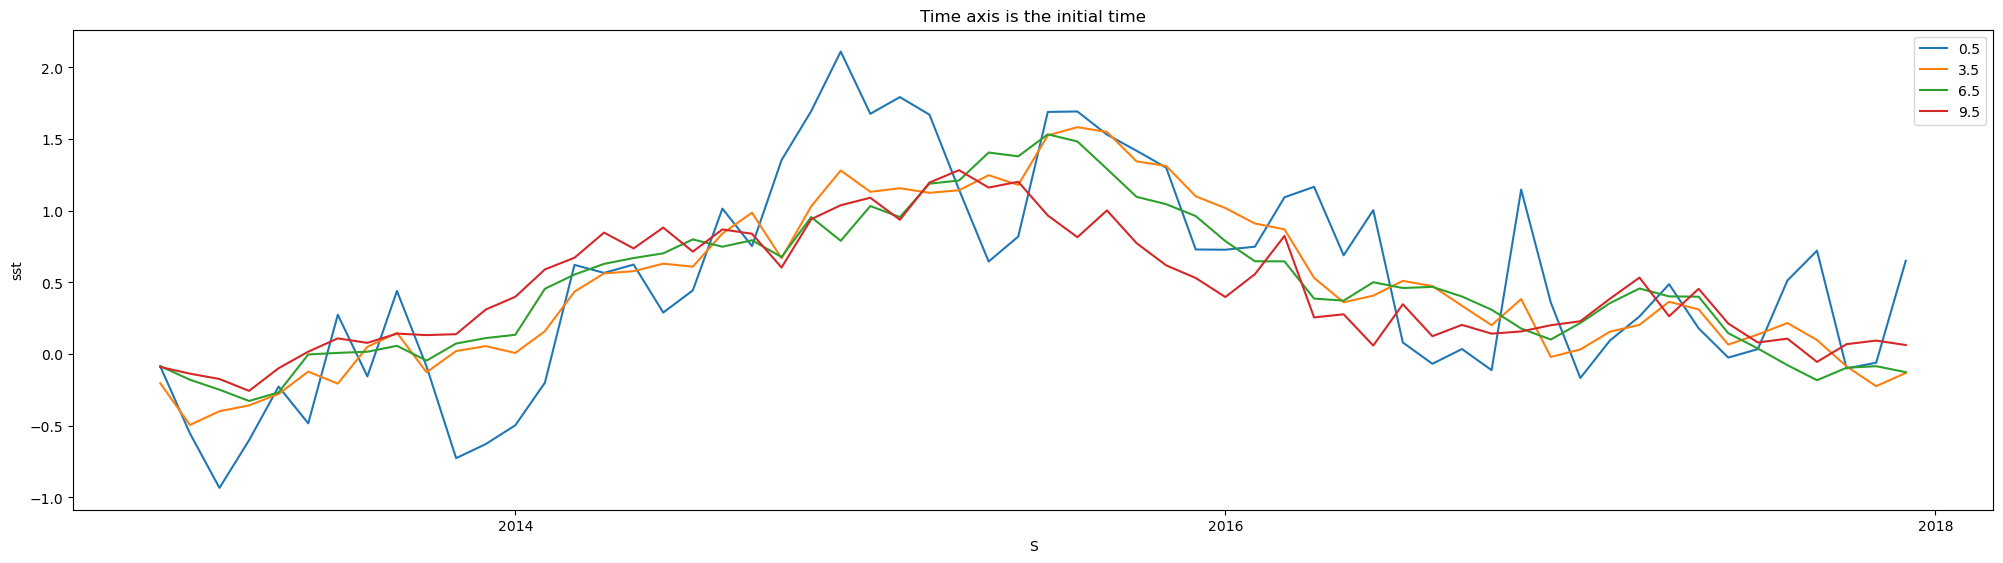

In [27]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for l in da_total_concat_mmm.L.data[::3]:
    da_total_concat_mmm.sel(S=slice('2013-01','2017-12')).sel(L=l).plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the initial time')

In [28]:
da_total_concat_mmm.sel(S='2015-10').sel(L=[0.5,3.5,6.5,9.5])

<xarray.DataArray 'sst' (L: 4, S: 1)> Size: 16B
array([[1.418662 ],
       [1.3443493],
       [1.0970438],
       [0.7737606]], dtype=float32)
Coordinates:
  * L        (L) float32 16B 0.5 3.5 6.5 9.5
  * S        (S) object 8B 2015-10-01 00:00:00
    month    (S) int64 8B 10

Text(0.5, 1.0, 'Time axis is the initial time')

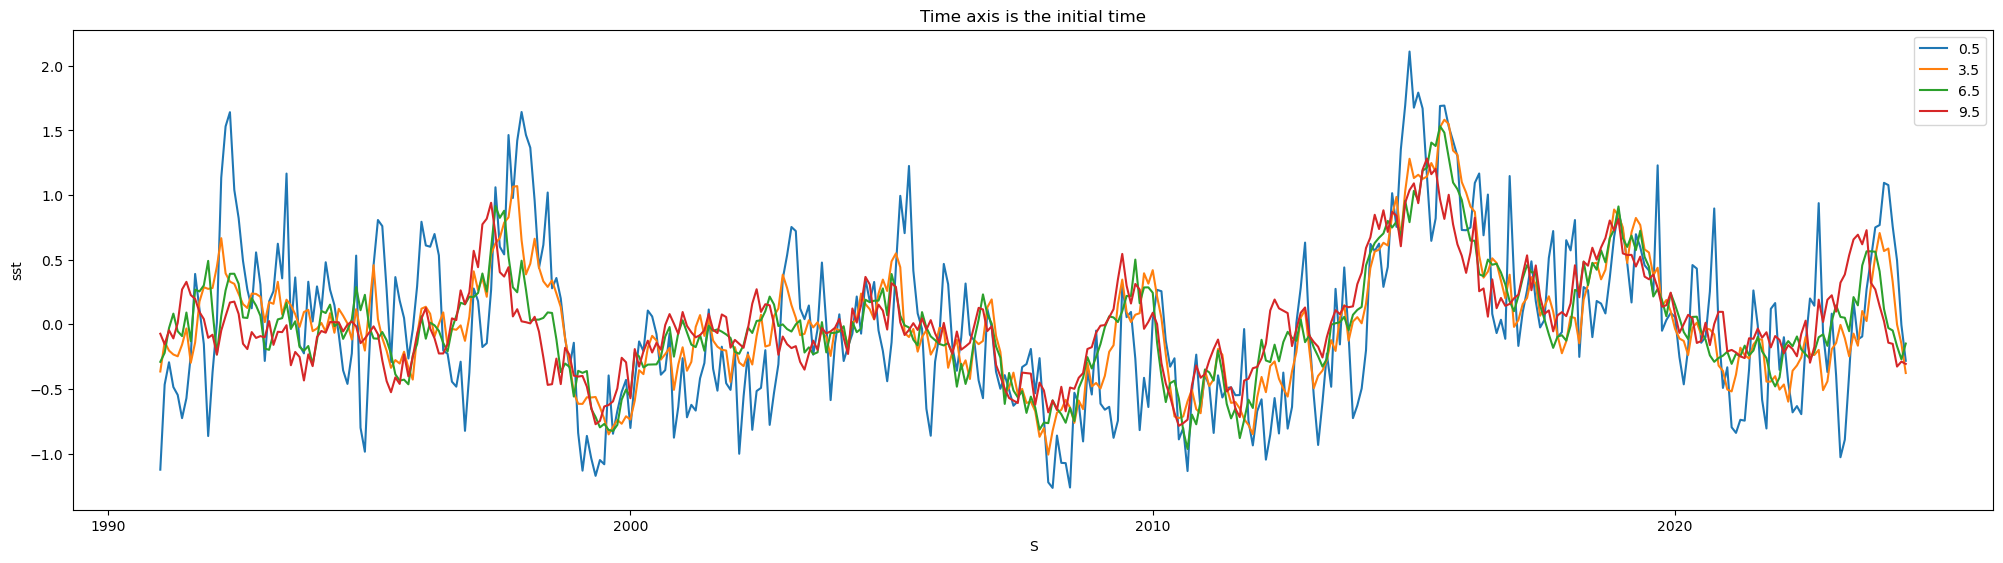

In [29]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for l in da_total_concat_mmm.L.data[::3]:
    da_total_concat_mmm.sel(L=l).plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the initial time')

Text(0.5, 1.0, 'Time axis is the initial time')

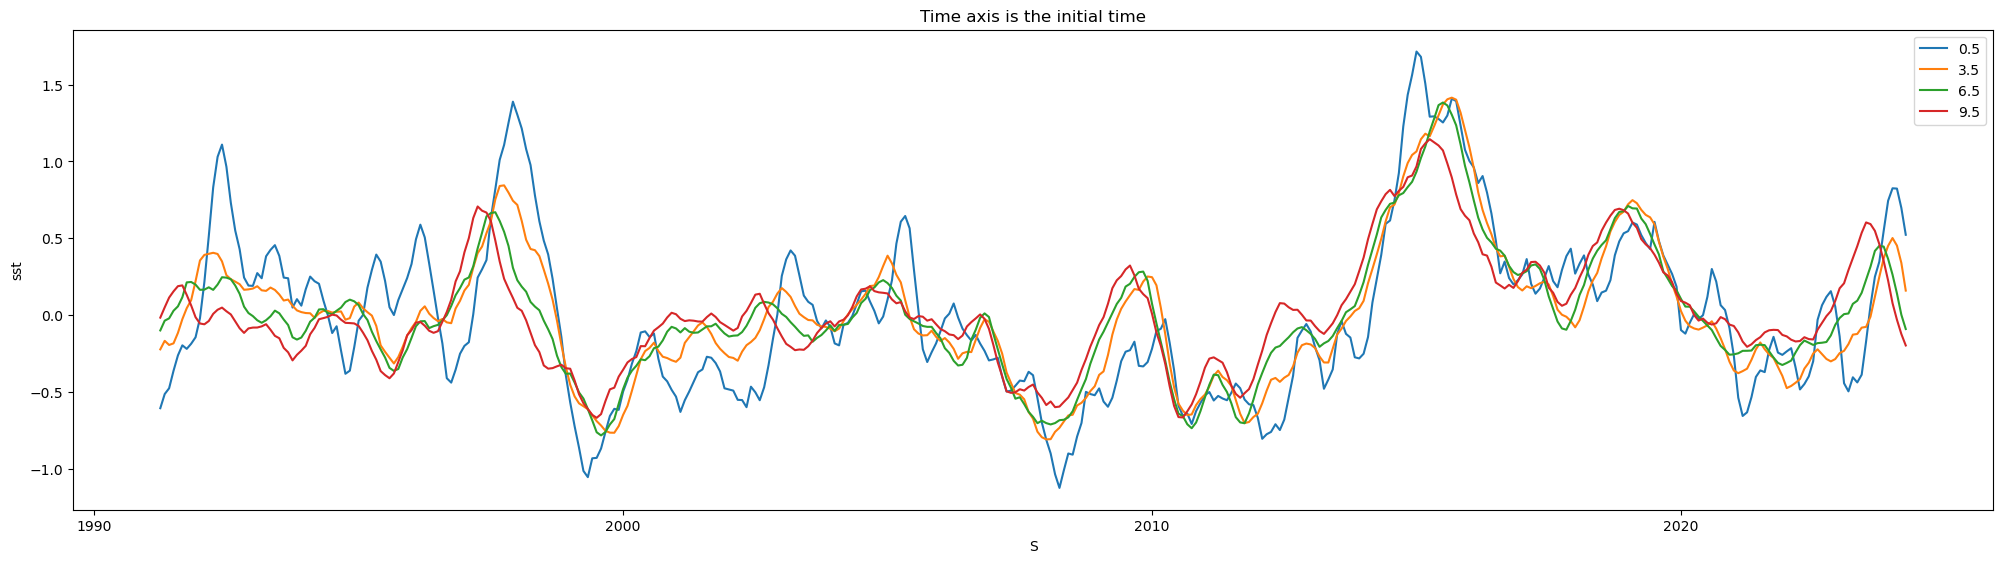

In [31]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for l in da_total_concat_mmm.L.data[::3]:
    da_total_concat_mmm.sel(L=l).rolling(S=6, center=True).mean().plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the initial time')

Text(0.5, 1.0, 'Time axis is the verification time')

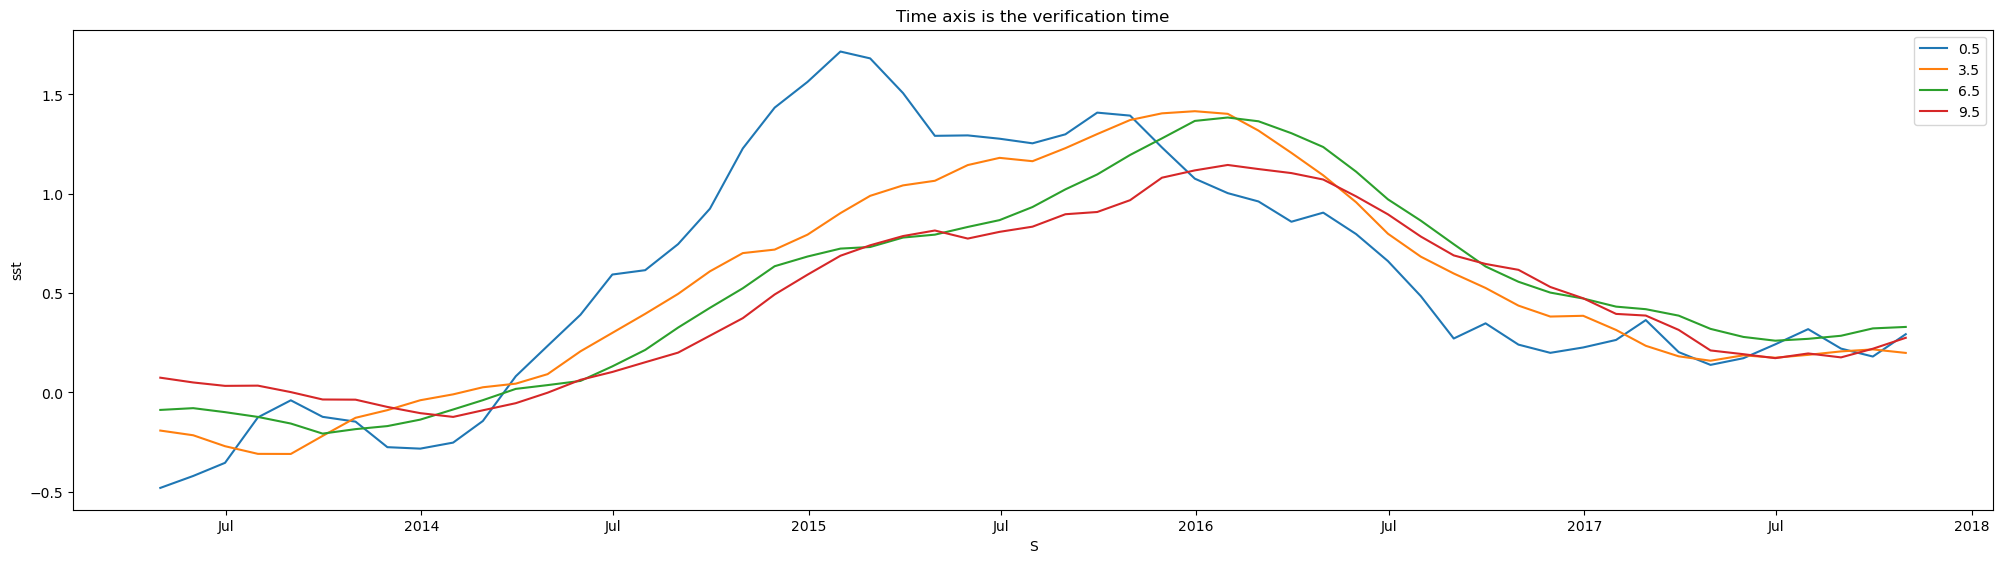

In [35]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
time = da_total_concat_mmm.S.data.copy()
for l in da_total_concat_mmm.L.data[::3]:
    da_crop = da_total_concat_mmm.sel(L=l)
    stime = int(np.floor(l))
    verification_time = xr.date_range(start=f'{time[stime].year:04d}-{time[stime].month:02d}', periods=len(da_total_concat_mmm.S.data), freq='M')
    da_crop['S'] = verification_time
    da_crop.sel(S=slice('2013-01','2017-12')).rolling(S=6, center=True).mean().plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the verification time')

Text(0.5, 1.0, 'Time axis is the verification time')

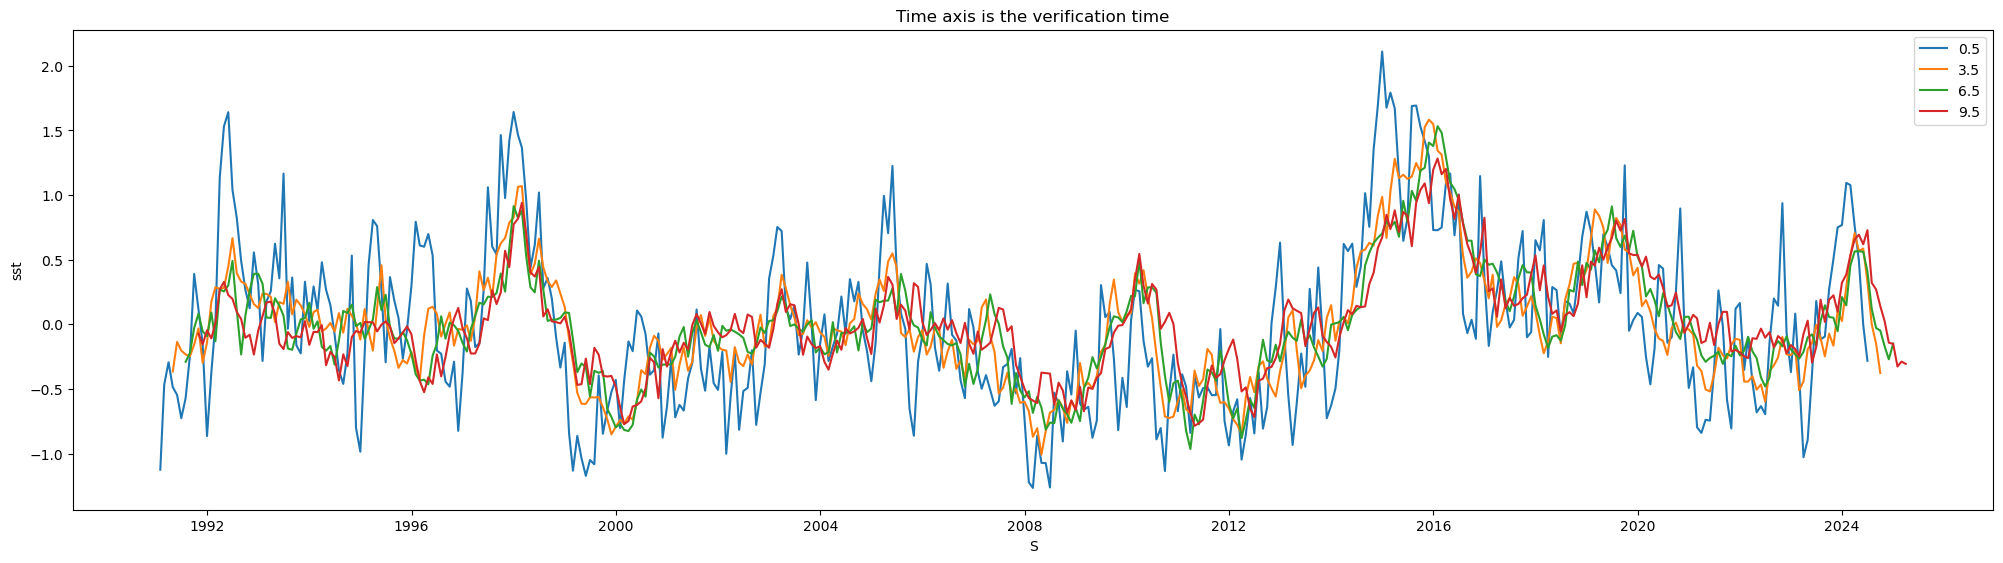

In [33]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
time = da_total_concat_mmm.S.data.copy()
for l in da_total_concat_mmm.L.data[::3]:
    da_crop = da_total_concat_mmm.sel(L=l)
    stime = int(np.floor(l))
    verification_time = xr.date_range(start=f'{time[stime].year:04d}-{time[stime].month:02d}', periods=len(da_total_concat_mmm.S.data), freq='M')
    da_crop['S'] = verification_time
    da_crop.plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the verification time')

Text(0.5, 1.0, 'Time axis is the verification time')

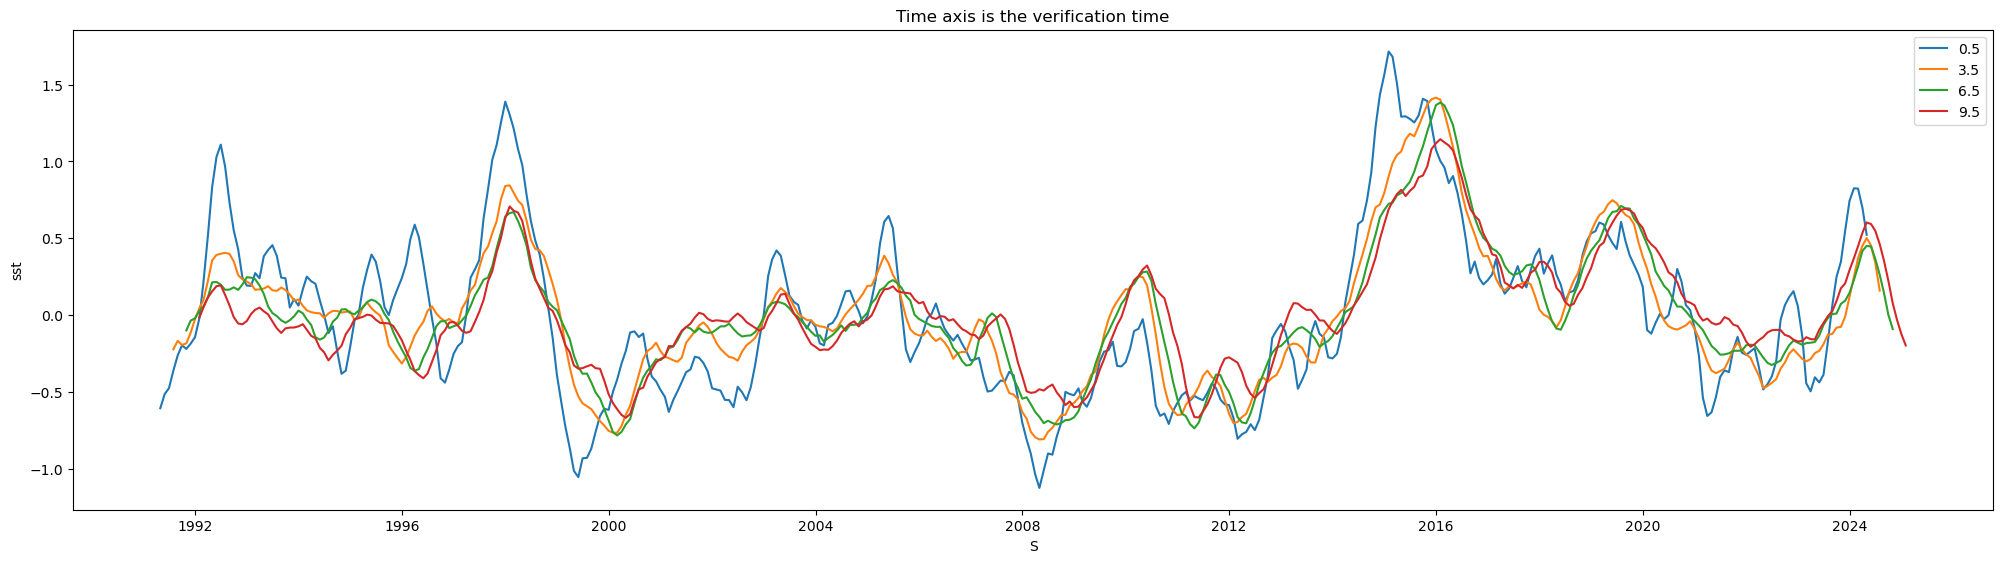

In [34]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
time = da_total_concat_mmm.S.data.copy()
for l in da_total_concat_mmm.L.data[::3]:
    da_crop = da_total_concat_mmm.sel(L=l)
    stime = int(np.floor(l))
    verification_time = xr.date_range(start=f'{time[stime].year:04d}-{time[stime].month:02d}', periods=len(da_total_concat_mmm.S.data), freq='M')
    da_crop['S'] = verification_time
    da_crop.rolling(S=6, center=True).mean().plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the verification time')